In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Multiply

# Load Model

In [ ]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def CBAM(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x


In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def build_model(input_shape):
    input_shape = (512,512,3)
    inputs = Input(input_shape)

    vgg_model = VGG16(include_top=False, weights="imagenet",input_tensor=inputs)
    vgg_model.trainable = False
    # vgg_model.summary()

    # Encoder
    s1 = vgg_model.layers[0].output                                             ## (512 x 512)
    s2 = vgg_model.get_layer("block2_conv2").output                             ## (256 x 256)
    s3 = vgg_model.get_layer("block3_conv3").output                             ## (128 x 128)
    s4 = vgg_model.get_layer("block4_conv3").output                             ## (64 x 64)

    b1 = vgg_model.get_layer("block5_conv3").output                             ## (32 x 32)

    # Attention 
    s1 = CBAM(s1)
    s2 = CBAM(s2)
    s3 = CBAM(s3)
    s4 = CBAM(s4)

    # Decoder
    d1 = decoder_block(b1, s4, 512)                                             ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                                             ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                                             ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                                              ## (512 x 512)

    # Output
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG_Model_LowLight_Enhancement")
    return model

In [ ]:
input_shape = (512, 512, 3)
#input_shape = (None, None, 3)
model = build_model(input_shape)
#model.summary()

58889256/58889256 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='block5_conv3/Relu:0', description="created by layer 'block5_conv3'")


In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_loss_fn(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

def ssim_loss_fn(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [ ]:
model_path = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/Test_VGG_LowLight_char_loss_v2.h5'

In [ ]:
from keras.models import load_model
model = load_model(model_path,custom_objects={'charbonnier_loss': charbonnier_loss,
                                              'psnr_loss_fn':psnr_loss_fn,
                                              'ssim_loss_fn':ssim_loss_fn},
                                              compile = False)

In [ ]:
IMAGE_WIDTH,IMAGE_HEIGHT = 512,512

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
def preprocess_image(img_path):
  img = load_image(img_path)
  img = tf.image.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
  img = img/255;
  return img

## **Image Folder**

In [ ]:
# train
#test_image_dir = r'/content/drive/MyDrive/FYP/YOLO_Results/Train'
# test_image_dir = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/testing_images_v3'
#test_image_dir = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low'
test_image_dir = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4'


# test
# test_image_dir = r'/content/drive/MyDrive/FYP/YOLO_Results/Test'

In [ ]:
# saving
save_dir = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1'
save_folder_name = 'Test_MIRNET_val_v6'
save_folder_path = os.path.join(save_dir,save_folder_name)

if not os.path.exists(save_folder_path):
  print("DIRECTORY CREATED")
  os.makedirs(save_folder_path)

DIRECTORY CREATED


1/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L1.png


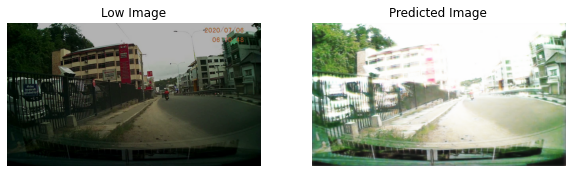

2/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L2.png


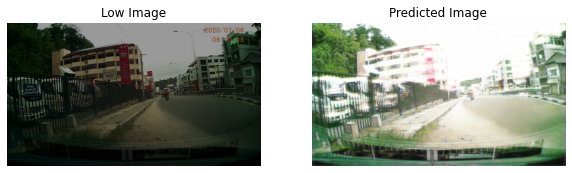

3/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L3 (1).png


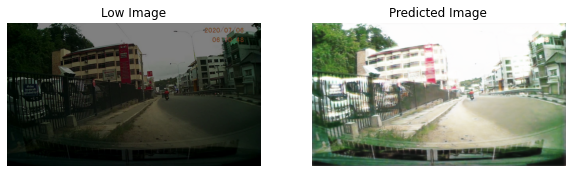

4/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L3.png


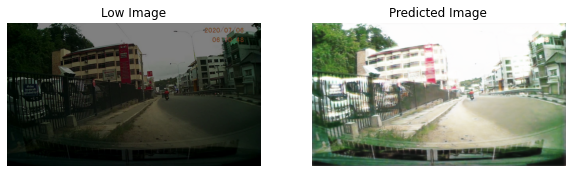

5/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L4 (1).png


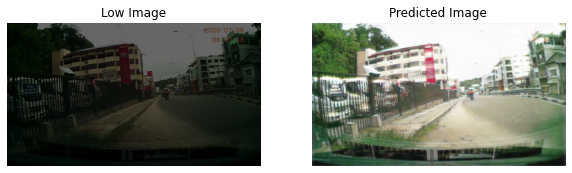

6/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L4.png


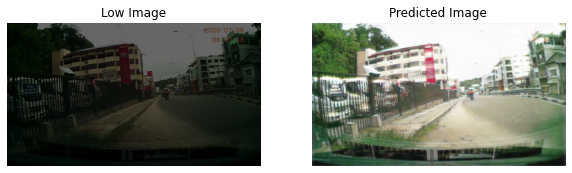

7/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L5.png


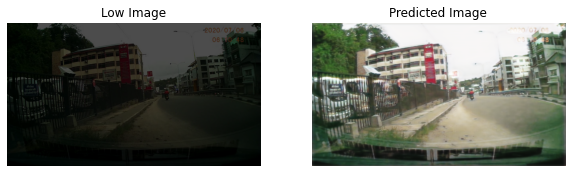

8/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L6.png


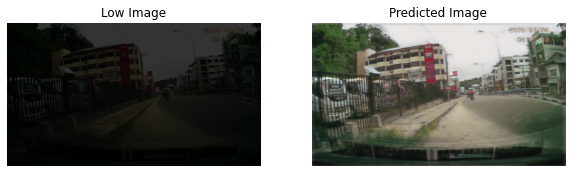

9/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L7.png


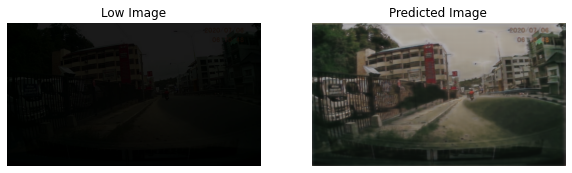

10/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_0_bg_L8.png


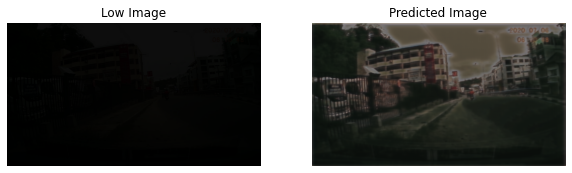

11/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/img_org.png


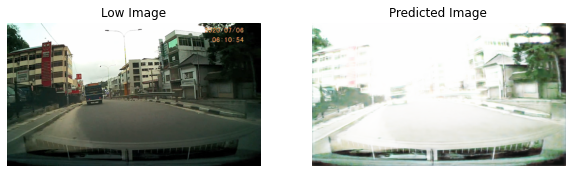

12/13 : /content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/test_4/Copy-of-IMG_7957-1-mov_Frame_720_jpg.rf.4f988c600fbf4d641dcf281e3341071f.png


InvalidArgumentError: ignored

In [ ]:
saved_images = os.listdir(save_folder_path)
test_images = os.listdir(test_image_dir)

#n_images = 20
n_images = len(test_images)
display = True

for i,image_name in enumerate(test_images):
  if i==n_images:
    break

  if image_name in saved_images:
    print(f"{i} Already Saved")
    continue
  image_path = os.path.join(test_image_dir,image_name)
  print(f'{i+1}/{n_images} : {image_path}')

  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  w,h = img.shape[0],img.shape[1]

  low_img = preprocess_image(image_path)
  prediction = model.predict(np.expand_dims(low_img,axis=0),verbose=0)

  out_frame = prediction[0]*255.0
  out_frame = out_frame.astype(np.uint8)
  out_frame = cv2.resize(out_frame,(h,w))

  if display:
    fig, ax = plt.subplots(ncols=2, figsize=(10,10));
    ax[0].imshow(img);
    ax[1].imshow(out_frame);

    ax[0].axis('off');
    ax[1].axis('off');
  
    ax[0].set_title("Low Image")
    ax[1].set_title("Predicted Image")
    plt.show()

  ### save
  #save_name = f'VGG_{image_name.split(".")[0]}.png'
  save_name = image_name
  save_path = os.path.join(save_folder_path,save_name)
  #fig.savefig(save_path,bbox_inches='tight',dpi=300);
  
  cv2.imwrite(save_path, out_frame)

## **Prediction for Image**

In [ ]:
test_lowimg_path = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/Copy-of-IMG_7957-1-mov_Frame_720_jpg.rf.4f988c600fbf4d641dcf281e3341071f.jpg'
test_highimg_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high/1.png'

In [ ]:
LowImg = preprocess_image(test_lowimg_path)
HighImg = preprocess_image(test_highimg_path)

In [ ]:
prediction = model.predict(np.expand_dims(LowImg,axis=0))

1/1 [==============================] - 9s 9s/step


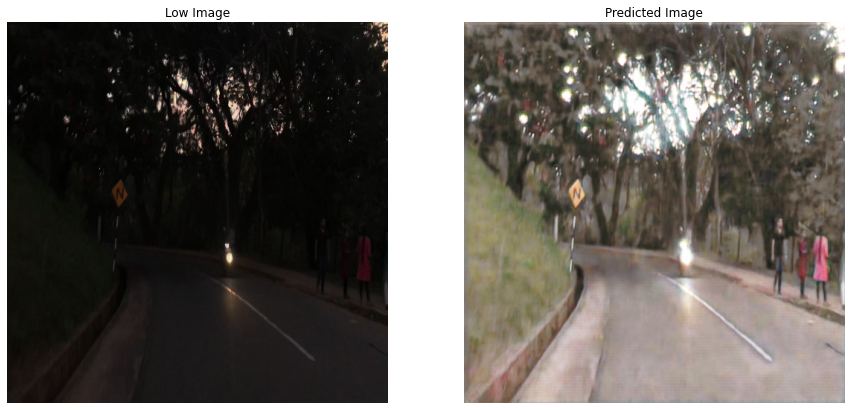

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10));
ax[0].imshow(LowImg);
ax[1].imshow(prediction[0]);

ax[0].axis('off');
ax[1].axis('off');

ax[0].set_title("Low Image")
ax[1].set_title("Predicted Image")
plt.show()

## **Video Prediction**

In [ ]:
IMAGE_WIDTH,IMAGE_HEIGHT = 512,512

In [ ]:
video_path = r'/content/drive/MyDrive/FYP/Datastets/Data_Primash/February /IMG_7948.mov'

Total Frames : 6651.0
FPS : 30.000676605245946
1080 1920


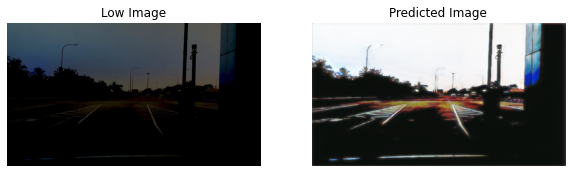

1080 1920


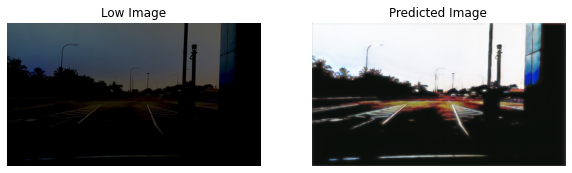

1080 1920


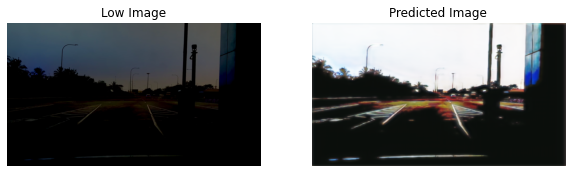

1080 1920


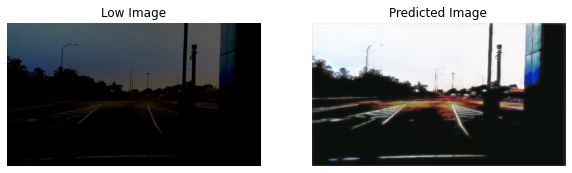

1080 1920


In [ ]:
cap = cv2.VideoCapture(video_path)

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'Total Frames : {total_frames}')
print(f'FPS : {fps}')

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret: break

    w,h = frame.shape[0],frame.shape[1]
    print(w,h)
    frame_count += 1
    if frame_count==5:
      break

    print("============")
    #img = tf.io.decode_jpeg(frame)
    img = tf.image.resize(frame, (IMAGE_WIDTH,IMAGE_HEIGHT))
    img_preprocess = img/255;

    prediction = model.predict(np.expand_dims(img_preprocess,axis=0),verbose=0)
    out_frame = cv2.resize(prediction[0],(h,w))

    fig, ax = plt.subplots(ncols=2, figsize=(10,10));
    ax[0].imshow(frame);
    ax[1].imshow(out_frame);
    ax[0].axis('off');
    ax[1].axis('off');
    ax[0].set_title("Low Image")
    ax[1].set_title("Predicted Image")
    plt.show()

cap.release()
cv2.destroyAllWindows()